# Part 2: Finding Optimal Anchor Configurations


If you know about the RetinaNet architecture, you probably will be able to deduce that the anchor box generator is not generating anchor boxes with a high enough IoU with the spectogram targets to have the boxes land in the training target.
This is apparent, as in part 1 you can see that the oblong boxes slip through the cracks.  In order to remedy this problem, lets find an optimal anchor box configuration.

Unfortunately, spectograms have little in common with typical images.  The size and aspect ratios of signals in a spectogram has nothing to do with the distribution of objects in the real world.  As such, we have to put a great deal of effort into finding optimal anchor configurations.

Lets explore our dataset to better understand the issue:

TODO overview of anchor boxes.

# Data Understanding

In [47]:
import em_loader
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [48]:
dataset, dataset_info = em_loader.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
    version=2,
)

## Aspect Ratio Analysis

Lets start by analyzing the aspect ratios in the dataset.

In [49]:
result = []

for batch in tqdm(iter(dataset)):
    boxes = batch['bounding_boxes']
    aspect_ratios = boxes[:, :, 2] / boxes [:, :, 3]
    aspect_ratios = aspect_ratios.to_tensor(-1.0)
    aspect_ratios = tf.reshape(aspect_ratios, (-1))
    aspect_ratios = tf.gather(aspect_ratios, tf.where(aspect_ratios != -1.0))
    result.append(aspect_ratios.numpy())
result = np.concatenate(result)
aspect_ratios = result

429it [00:20, 20.88it/s]


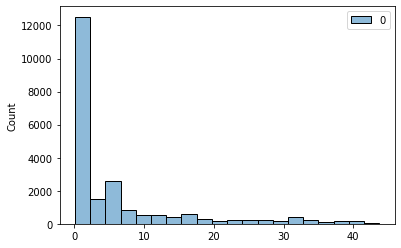

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(aspect_ratios, bins=20)
plt.savefig('artifacts/k-means/aspect-ratios.png')

## Area

In [51]:
import numpy as np
from tqdm import tqdm
result = []
for batch in tqdm(iter(dataset)):
    boxes = batch['bounding_boxes']
    area = boxes[:, :, 2] * boxes [:, :, 3]
    area = area.to_tensor(-1.0)
    area = tf.reshape(area, (-1))
    side_lengths = tf.math.sqrt(tf.gather(area, tf.where(area != -1.0)))
    result.append(side_lengths.numpy())
side_lengths = np.concatenate(result)

429it [00:20, 21.21it/s]


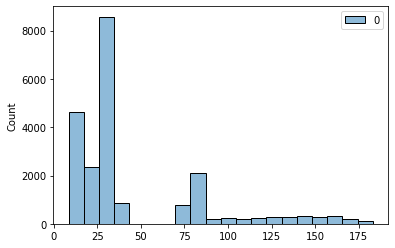

In [52]:
import seaborn as sns
sns.histplot(side_lengths, bins=20)
plt.savefig('artifacts/k-means/side-lengths.png')

## K Means

# PascalVOC

In [53]:
import keras_cv
dataset, dataset_info = keras_cv.datasets.pascal_voc.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
)

In [54]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
result = []

for batch in tqdm(iter(dataset)):
    boxes = batch['bounding_boxes']
    aspect_ratios = boxes[:, :, 2] / boxes [:, :, 3]
    aspect_ratios = aspect_ratios.to_tensor(-1.0)
    aspect_ratios = tf.reshape(aspect_ratios, (-1))
    aspect_ratios = tf.gather(aspect_ratios, tf.where(aspect_ratios != -1.0))
    result.append(aspect_ratios.numpy())
result = np.concatenate(result)
aspect_ratios = result

278it [00:04, 68.17it/s]


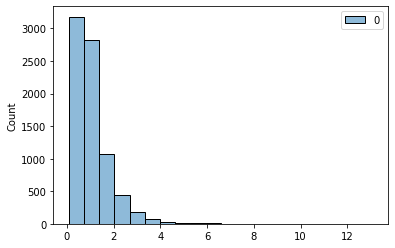

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(aspect_ratios, bins=20)
plt.savefig('artifacts/k-means/pascal-voc-aspect-ratios.png')

In [36]:
import numpy as np
from tqdm import tqdm
result = []
for batch in tqdm(iter(dataset)):
    boxes = batch['bounding_boxes']
    area = boxes[:, :, 2] * boxes [:, :, 3]
    area = area.to_tensor(-1.0)
    area = tf.reshape(area, (-1))
    side_lengths = tf.math.sqrt(tf.gather(area, tf.where(area != -1.0)))
    result.append(side_lengths.numpy())
side_lengths = np.concatenate(result)

278it [00:03, 71.02it/s]


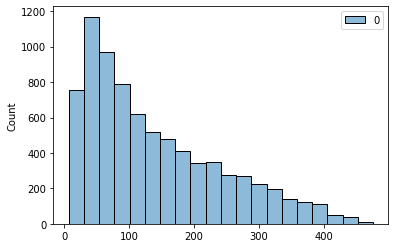

In [37]:
import seaborn as sns
sns.histplot(side_lengths, bins=20)
plt.savefig('artifacts/k-means/pascal-voc-side-lengths.png')

# K-Means Clustering

Lets implement K-Means clustering to find an optimal set of anchor generators.

First, we need to get the box widths and heights

In [55]:
dataset, dataset_info = em_loader.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
    version=2,
)

In [56]:
result = []

for batch in tqdm(iter(dataset)):
    boxes = batch['bounding_boxes']
    box_height = boxes[:, :, 3]
    box_height = box_height.to_tensor(-1.0)
    box_height = tf.reshape(box_height, (-1))
    box_height = tf.gather(box_height, tf.where(box_height != -1.0))
    result.append(box_height.numpy())
result = np.concatenate(result)
box_height = result

429it [00:20, 21.32it/s]


In [ ]:
result = []

for batch in tqdm(iter(dataset)):
    boxes = batch['bounding_boxes']
    box_width = boxes[:, :, 2]
    box_width = box_width.to_tensor(-1.0)
    box_width = tf.reshape(box_width, (-1))
    box_width = tf.gather(box_width, tf.where(box_width != -1.0))
    result.append(box_width.numpy())
result = np.concatenate(result)
box_width = result

92it [00:04, 21.11it/s]

In [ ]:
box_height = box_height.squeeze(axis=-1)
box_width = box_width.squeeze(axis=-1)

Next, we need to fit KMeans on the dataset

In [ ]:
X = np.array(list(zip(box_width,box_height)))
print('Input data:', X.shape)
print(X.shape)

In [ ]:
kmeans = KMeans(n_clusters=6,random_state=33).fit(X)

In [ ]:
plt.figure()
plt.scatter(X[:,0],X[:,1])
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1])
plt.xlabel("Box Width")
plt.ylabel("Box Height")
plt.title("Box Width vs. Box Height")
plt.grid()
plt.savefig('artifacts/k-means/scatter-plot')

Using this scatter plot, we can compute the box mean aspect ratios:

In [ ]:
aspect_ratios = sorted(kmeans.cluster_centers_[:,1] / kmeans.cluster_centers_[:,0])
print(f"aspect_ratios={aspect_ratios}")